In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import scanpy as sc
import paste as pst
import ot

In [2]:
# sample_names = ["anterior1","anterior2"]
sample_names = ["posterior1","posterior2"]
# sample_names = ["Anterior1","Posterior1"]
# sample_names = ["Anterior2","Posterior2"]
input_dir = 'G:/dataset/2_saggital/input/'
output_dir = 'G:/dataset/2_saggital/output/PASTE/'

# Load Slices

In [3]:
data_dir = input_dir    # change this path to the data you wish to analyze

# Assume that the coordinates of slices are named slice_name + "_coor.csv"
def load_slices(data_dir, slice_names = sample_names):
    slices = []  
    for slice_name in slice_names:
        print(slice_name)
        ### get anndata
        slice_i = sc.read_visium(input_dir + slice_name)
        slice_i.var_names_make_unique()
        # load by meta + coor
        # slice_i = sc.read_csv(data_dir + slice_name + ".csv")
        # slice_i_coor = np.genfromtxt(data_dir + slice_name + "_coor.csv", delimiter = ',')
        # slice_i.obsm['spatial'] = slice_i_coor
        
        ### Preprocess slices
        sc.pp.filter_genes(slice_i, min_counts = 15)
        sc.pp.filter_cells(slice_i, min_counts = 100)
        slices.append(slice_i)
    return slices

slices = load_slices(data_dir)
slice1, slice2 = slices

posterior1


D:\anaconda\envs\paste\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\anaconda\envs\paste\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


posterior2


D:\anaconda\envs\paste\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\anaconda\envs\paste\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
print(slice1)
print(slice2)

AnnData object with n_obs × n_vars = 3345 × 16013
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'
    uns: 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 3293 × 15843
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'
    uns: 'spatial'
    obsm: 'spatial'


# run PASTE

gpu is available, using gpu.


D:\anaconda\envs\paste\lib\site-packages\ot\lp\__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


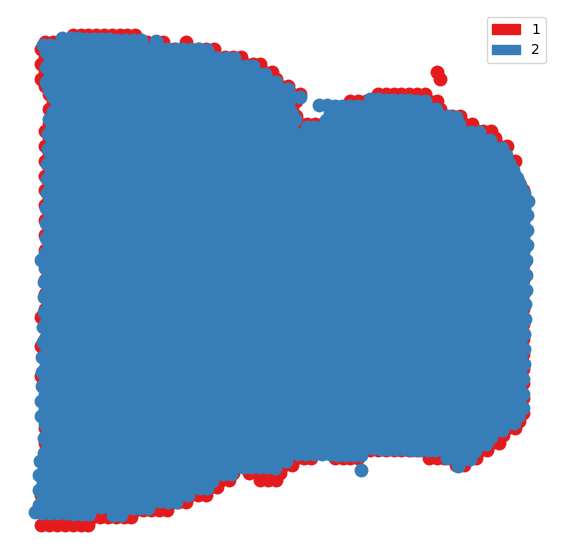

In [5]:
# Pairwise align the slices
# pi12 = pst.pairwise_align(slice1, slice2)
pi12 = pst.pairwise_align(slice1, slice2, backend = ot.backend.TorchBackend(), use_gpu = True)

# To visualize the alignment you can stack the slices 
# according to the alignment pi
slices, pis = [slice1, slice2], [pi12]
new_slices = pst.stack_slices_pairwise(slices, pis)
slice_colors = ['#e41a1c','#377eb8']
plt.figure(figsize=(7,7))
for i in range(len(new_slices)):
    pst.plot_slice(new_slices[i],slice_colors[i],s=400)
plt.legend(handles=[mpatches.Patch(color=slice_colors[0], label='1'),mpatches.Patch(color=slice_colors[1], label='2')])
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

In [6]:
new_coord=np.vstack((new_slices[0].obsm['spatial'],
                    new_slices[1].obsm['spatial']))
cells=np.hstack((new_slices[0].obs_names,new_slices[1].obs_names))
print(new_coord.shape)
print(cells.shape)

(6638, 2)
(6638,)


In [7]:
# save coor
new_coord=np.vstack((new_slices[0].obsm['spatial'],
                    new_slices[1].obsm['spatial']))
cells=np.hstack((new_slices[0].obs_names,new_slices[1].obs_names))
new_coord=pd.DataFrame(new_coord,index=cells,columns=['x','y'])
new_coord.to_csv(output_dir + "paste_coord_"+sample_names[0]+"_"+sample_names[1]+".csv")

In [7]:
# Center align slices
## We have to reload the slices as pairwise_alignment modifies the slices.
slices = load_slices(data_dir)
slice1, slice2 = slices

# Construct a center slice
## choose one of the slices as the coordinate reference for the center slice,
## i.e. the center slice will have the same number of spots as this slice and
## the same coordinates.
initial_slice = slice1.copy()    
slices = [slice1, slice2]
lmbda = len(slices)*[1/len(slices)] # set hyperparameter to be uniform

## Possible to pass in an initial pi (as keyword argument pis_init) 
## to improve performance, see Tutorial.ipynb notebook for more details.
# center_slice, pis = pst.center_align(initial_slice, slices, lmbda) 
center_slice, pis = pst.center_align(initial_slice, slices, lmbda, backend = ot.backend.TorchBackend(), use_gpu = True) 

## The low dimensional representation of our center slice is held 
## in the matrices W and H, which can be used for downstream analyses
W = center_slice.uns['paste_W']
H = center_slice.uns['paste_H']

Anterior2


D:\anaconda\envs\PASTE\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\anaconda\envs\PASTE\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Posterior2


D:\anaconda\envs\PASTE\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\anaconda\envs\PASTE\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


gpu is available, using gpu.
Filtered all slices for common genes. There are 15832 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem.


D:\anaconda\envs\PASTE\lib\site-packages\ot\lp\__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
D:\anaconda\envs\PASTE\lib\site-packages\ot\lp\__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Solving Center Mapping NMF Problem.
Objective  -6149785.0
Difference: 6149785.0

Iteration: 1
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.


D:\anaconda\envs\PASTE\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Objective  20935.49741959572
Difference: 6170720.497419596

Iteration: 2
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.


D:\anaconda\envs\PASTE\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Objective  20936.70372915268
Difference: 1.2063095569610596

Iteration: 3
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.
Objective  20936.903388261795
Difference: 0.19965910911560059

Iteration: 4
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.
Objective  20936.703632354736
Difference: 0.19975590705871582

Iteration: 5
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.
Objective  20936.905263900757
Difference: 0.2016315460205078

Iteration: 6
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.


D:\anaconda\envs\PASTE\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Objective  20936.703628063202
Difference: 0.20163583755493164

Iteration: 7
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.


D:\anaconda\envs\PASTE\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Objective  20936.903287887573
Difference: 0.1996598243713379

Iteration: 8
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.
Objective  20936.704057216644
Difference: 0.19923067092895508

Iteration: 9
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.
Objective  20936.904829978943
Difference: 0.20077276229858398



In [8]:
print(type(W))
print(type(H))
print(W)
print(H)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[[6.88458607e-02 9.83002558e-02 9.90510657e-02 ... 1.03723383e+00
  2.65652061e-01 1.05621016e+00]
 [3.62577826e-01 3.39563712e-02 7.39923716e-02 ... 4.07164544e-02
  9.69450846e-02 2.25352302e-01]
 [1.01862419e+00 1.22313172e-01 3.54814696e+00 ... 3.98619920e-01
  8.94310698e-02 3.56705338e-01]
 ...
 [2.60593563e-01 9.62332249e-01 8.46265495e-01 ... 1.26591235e-01
  9.55207288e-01 1.05800085e-01]
 [2.75659928e-04 1.56989507e-02 2.79270619e-01 ... 2.87035567e-04
  1.97962075e-01 1.02494645e-03]
 [1.83711454e-01 9.21730250e-02 1.14780165e-01 ... 6.47140741e-01
  2.40717351e-01 7.00030252e-02]]
[[1.2216192e-02 8.0090696e-03 3.4655269e-02 ... 1.4592937e-02
  1.3880017e-02 1.5070422e+00]
 [3.9928863e-03 6.4994718e-05 3.3852629e-02 ... 1.0586824e-02
  7.1651801e-03 8.7887806e-01]
 [2.6046906e-05 5.4718308e-10 4.2002171e-02 ... 7.3107826e-03
  2.3821673e-04 5.5868024e-01]
 ...
 [8.2181134e-07 1.6071709e-03 3.4458379e-03 ... 1.2006111e-03
  1.64

In [9]:
print(W.shape)
print(H.shape)

(2825, 15)
(15, 15832)


In [10]:
np.savetxt(output_dir + sample_names[0]+"_"+sample_names[1]+"_W.csv", W, delimiter=",")
np.savetxt(output_dir + sample_names[0]+"_"+sample_names[1]+"_H.csv", H, delimiter=",")